7.6

In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [573]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import statsmodels.api as sm
from ISLP import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_val_score,
                                     cross_validate)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler,
                                   PolynomialFeatures)
from ISLP.models import (summarize, 
                        poly,
                        ModelSpec as MS)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings; warnings.simplefilter('ignore')


In [334]:
wage = load_data('Wage')
wage

year  age            maritl      race        education  \
0     2006   18  1. Never Married  1. White     1. < HS Grad   
1     2004   24  1. Never Married  1. White  4. College Grad   
2     2003   45        2. Married  1. White  3. Some College   
3     2003   43        2. Married  3. Asian  4. College Grad   
4     2005   50       4. Divorced  1. White       2. HS Grad   
...    ...  ...               ...       ...              ...   
2995  2008   44        2. Married  1. White  3. Some College   
2996  2007   30        2. Married  1. White       2. HS Grad   
2997  2005   27        2. Married  2. Black     1. < HS Grad   
2998  2005   27  1. Never Married  1. White  3. Some College   
2999  2009   55      5. Separated  1. White       2. HS Grad   

                  region        jobclass          health health_ins   logwage  \
0     2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.318063   
1     2. Middle Atlantic  2. Information  2. >=Very Good      2. No  4.255273   
2     2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.875061   
3     2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes  5.041393   
4     2. Middle Atlantic  2. Information       1. <=Good     1. Yes  4.318063   
...                  ...             ...             ...        ...       ...   
2995  2. Middle Atlantic   1. Industrial  2. >=Very Good     1. Yes  5.041393   
2996  2. Middle Atlantic   1. Industrial  2. >=Very Good      2. No  4.602060   
2997  2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.193125   
2998  2. Middle Atlantic   1. Industrial  2. >=Very Good     1. Yes  4.477121   
2999  2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.505150   

            wage  
0      75.043154  
1      70.476020  
2     130.982177  
3     154.685293  
4      75.043154  
...          ...  
2995  154.685293  
2996   99.689464  
2997   66.229408  
2998   87.981033  
2999   90.481913  

[3000 rows x 11 columns]

(a)

Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [335]:
y = wage['wage']
age = wage['age'].values.reshape(-1,1)

degree = range(0,11)
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('estimator', LinearRegression())])
pipe.fit(age,y)

param_grid = {'poly__degree': degree}
K = 5
kfold = skm.KFold(K,
                 random_state=0,
                 shuffle=True)
grid = skm.GridSearchCV(pipe,
                       param_grid,
                       cv=5,
                       scoring='neg_mean_squared_error')
grid.fit(age,y)

res = -grid.cv_results_['mean_test_score']

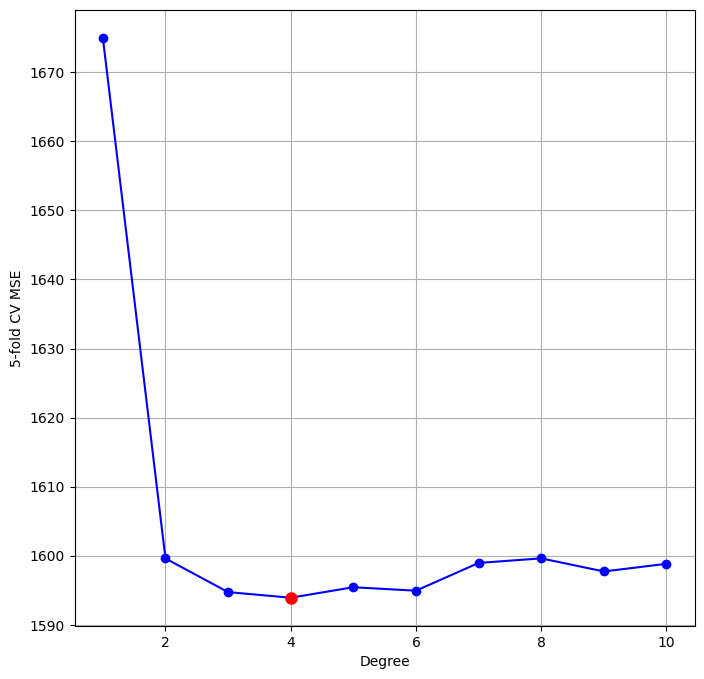

In [336]:
fig_poly, ax = subplots(figsize=(8,8))
ax.plot(np.arange(0,11), list(res), marker = 'o', color = 'b')
ax.plot(np.nanargmin(list(res)),np.nanmin(res), marker='o', markersize=8, color='red')
ax.set_xlabel('Degree')
ax.set_ylabel('5-fold CV MSE')
ax.grid()

We see that the minimum occurs at the degree 7 in polynomial regression.

In [337]:
polyn = PolynomialFeatures(degree=9)
X1 = polyn.fit_transform(wage['age'].to_frame())
#design = MS([poly('age',degree=9)]).fit(wage)
#X = design.transform(wage)
#X_new = (X-np.mean(X))/np.std(X)
#X
X = pd.DataFrame(X1)

fit1 = sm.OLS(y,X.iloc[:,:1]).fit() # degree 1
fit2 = sm.OLS(y,X.iloc[:,:2]).fit() # degree 2
fit3 = sm.OLS(y,X.iloc[:,:3]).fit() # degree 3
fit4 = sm.OLS(y,X.iloc[:,:4]).fit() # degree 4
fit5 = sm.OLS(y,X.iloc[:,:5]).fit() # degree 5
fit6 = sm.OLS(y,X.iloc[:,:6]).fit() # degree 6
fit7 = sm.OLS(y,X.iloc[:,:7]).fit() # degree 7
fit8 = sm.OLS(y,X.iloc[:,:8]).fit() # degree 8
fit9 = sm.OLS(y,X.iloc[:,:9]).fit() # degree 9

table = sm.stats.anova_lm(fit1,fit2,fit3,fit4,fit5,fit6,fit7,fit8,fit9)
print(table)



   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2999.0  5.222086e+06      0.0            NaN         NaN           NaN
1    2998.0  5.022216e+06      1.0  199869.664970  125.565233  1.404041e-28
2    2997.0  4.793430e+06      1.0  228786.010128  143.731510  2.211791e-32
3    2996.0  4.777674e+06      1.0   15755.693664    9.898287  1.670556e-03
4    2995.0  4.771604e+06      1.0    6070.152124    3.813485  5.093457e-02
5    2994.0  4.770322e+06      1.0    1282.563017    0.805752  3.694514e-01
6    2993.0  4.766389e+06      1.0    3932.257651    2.470384  1.161153e-01
7    2993.0  4.764599e+06     -0.0    1790.520659        -inf           NaN
8    2993.0  4.764136e+06     -0.0     462.425217        -inf           NaN


From the anova table we can estimate that the prefered degree is $d=3$.

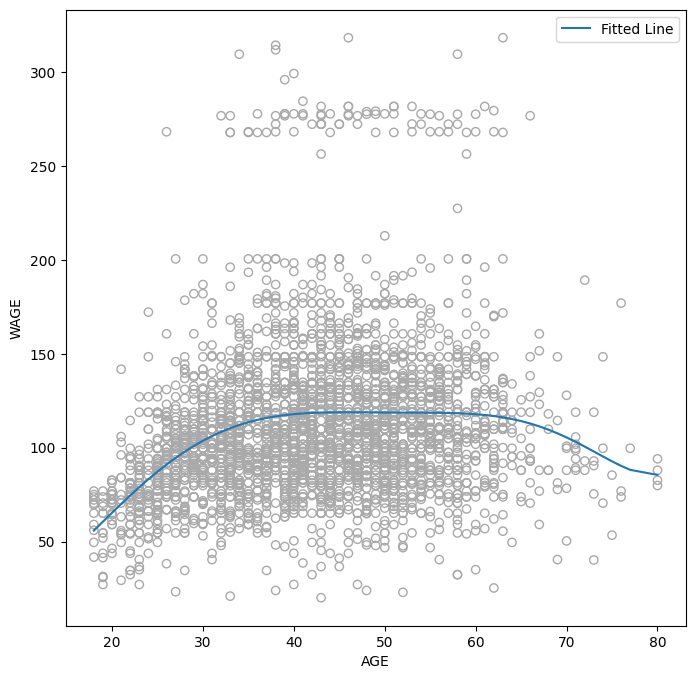

In [338]:
d = 7
poly = PolynomialFeatures(degree=d)
X = poly.fit_transform(wage['age'].to_frame())

model = LinearRegression()
model.fit(X,y)

pred = model.predict(X)

#pred = model.predict(X_test)
fig_poly, ax = subplots(figsize=(8,8))
ax.scatter(wage['age'],wage['wage'],facecolors='none', edgecolors='darkgray')
sns.lineplot(x=wage['age'],y=pred,label = 'Fitted Line')
ax.set_xlabel('AGE')
ax.set_ylabel('WAGE')
ax.legend()


(b)

Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

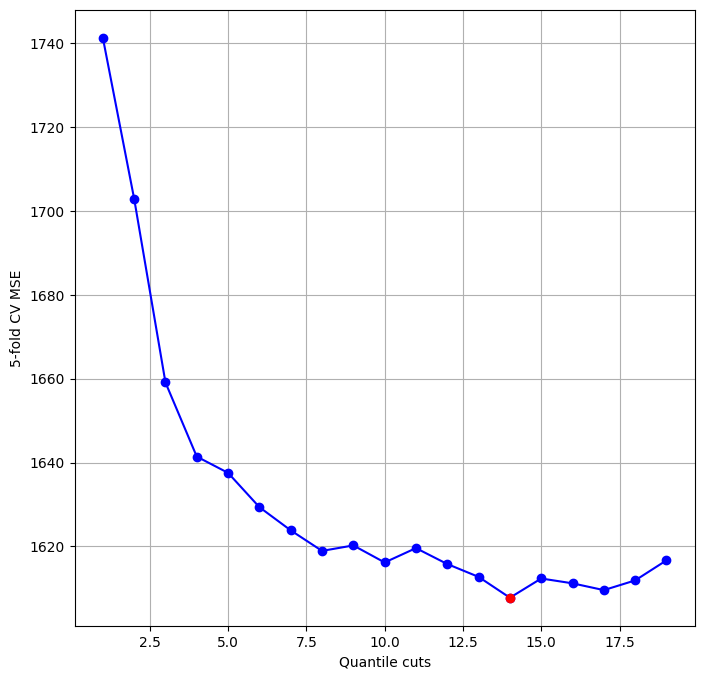

In [339]:
y = wage['wage']
X = wage['age']


def qcut(train_X,train_y,param):
    scores = []
    for cut in param:
        qcut = pd.qcut(X,q=cut)
        q_score = -np.mean(cross_val_score(LinearRegression(),pd.get_dummies(qcut),y,scoring='neg_mean_squared_error',cv=5))
        scores.append(q_score)
    return scores

param = range(1,20)
score_q = qcut(X,y,param)
qcut = pd.qcut(X,10)

fig, ax = subplots(figsize=(8,8))
ax.plot(param,score_q, marker='o',color='b')
ax.plot(np.argmin(score_q)+1,np.min(score_q),marker='o',color='r')
ax.set_xlabel('Quantile cuts')
ax.set_ylabel('5-fold CV MSE')
ax.grid()

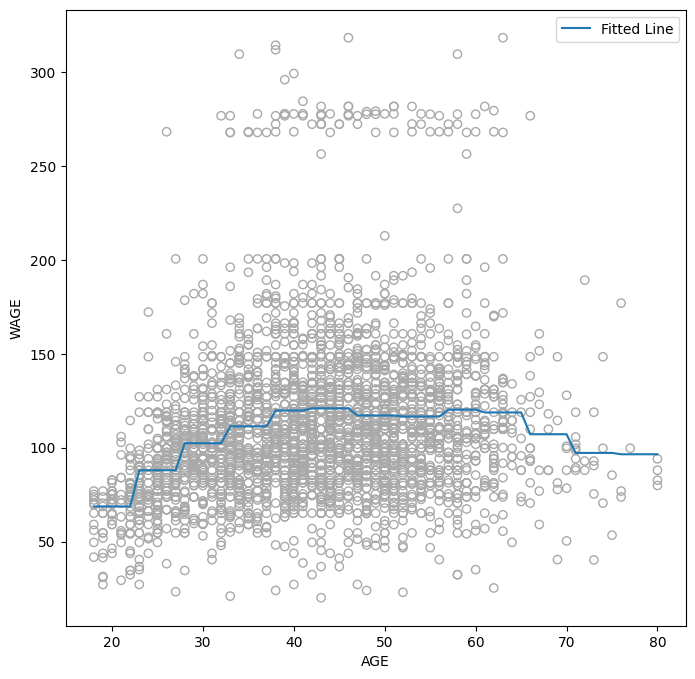

In [340]:
X_cut = pd.cut(X,np.argmin(score_q))
X_dummies = pd.get_dummies(X_cut)

model = sm.OLS(y,X_dummies).fit()
preds = model.predict(X_dummies)

fig_poly, ax = subplots(figsize=(8,8))
ax.scatter(wage['age'],wage['wage'],facecolors='none', edgecolors='darkgray')
sns.lineplot(x=wage['age'],y=preds,label = 'Fitted Line')
ax.set_xlabel('AGE')
ax.set_ylabel('WAGE')
ax.legend()

7.8

Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [341]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import statsmodels.api as sm
from ISLP import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler,
                                   PolynomialFeatures)
from ISLP.models import (summarize, 
                        poly,
                        ModelSpec as MS)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings; warnings.simplefilter('ignore')

In [342]:
auto = load_data('Auto')
auto.head()

mpg  cylinders  displacement  horsepower  weight  \
name                                                                           
chevrolet chevelle malibu  18.0          8         307.0         130    3504   
buick skylark 320          15.0          8         350.0         165    3693   
plymouth satellite         18.0          8         318.0         150    3436   
amc rebel sst              16.0          8         304.0         150    3433   
ford torino                17.0          8         302.0         140    3449   

                           acceleration  year  origin  
name                                                   
chevrolet chevelle malibu          12.0    70       1  
buick skylark 320                  11.5    70       1  
plymouth satellite                 11.0    70       1  
amc rebel sst                      12.0    70       1  
ford torino                        10.5    70       1

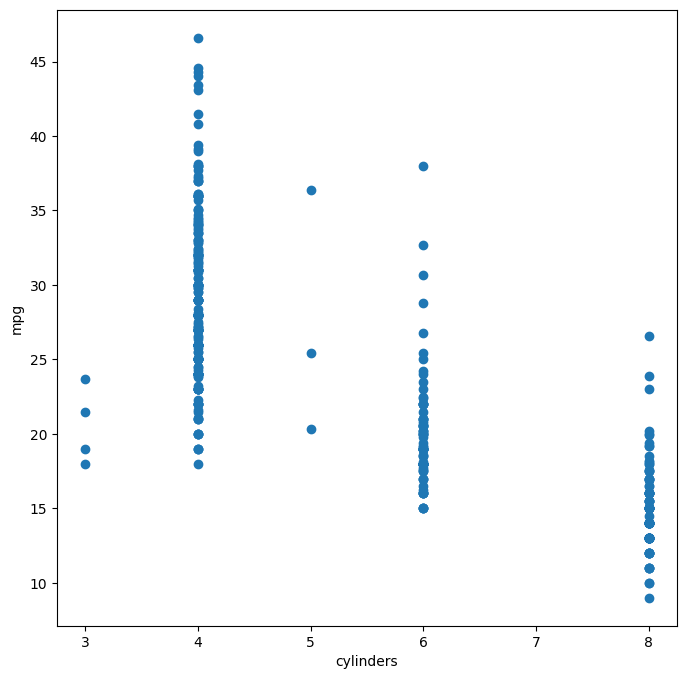

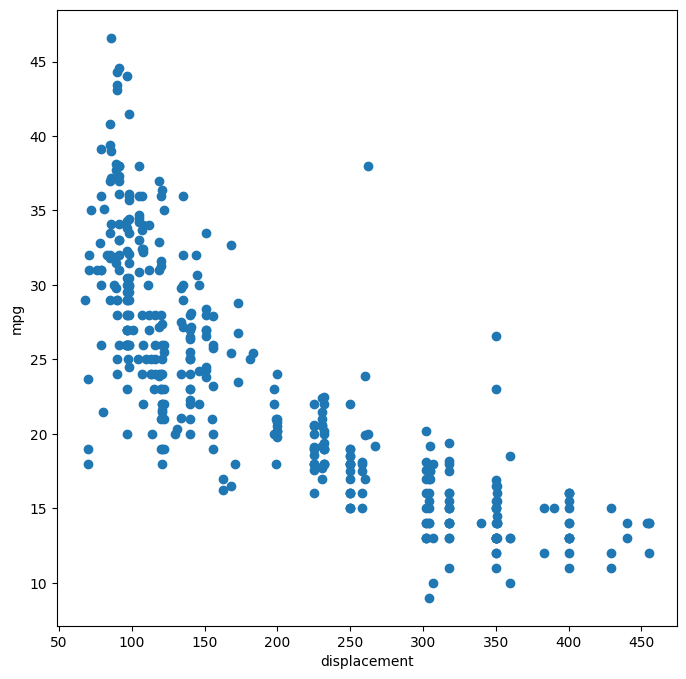

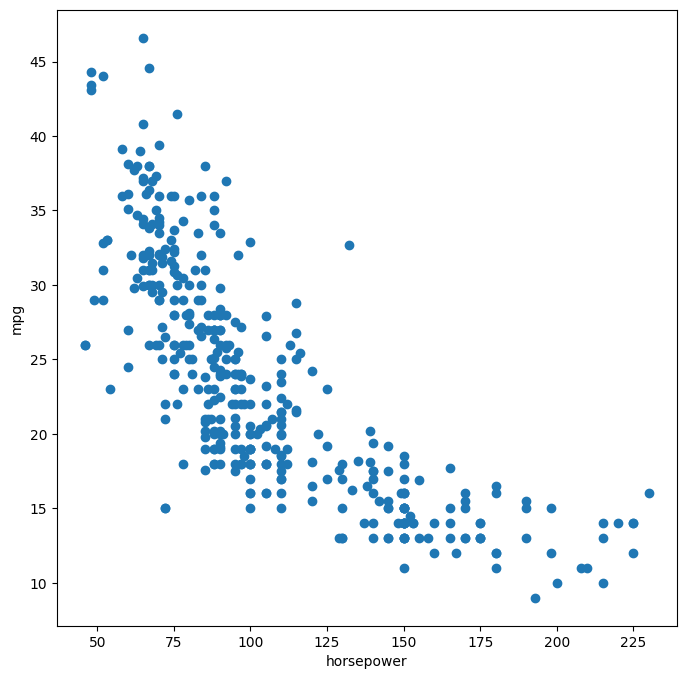

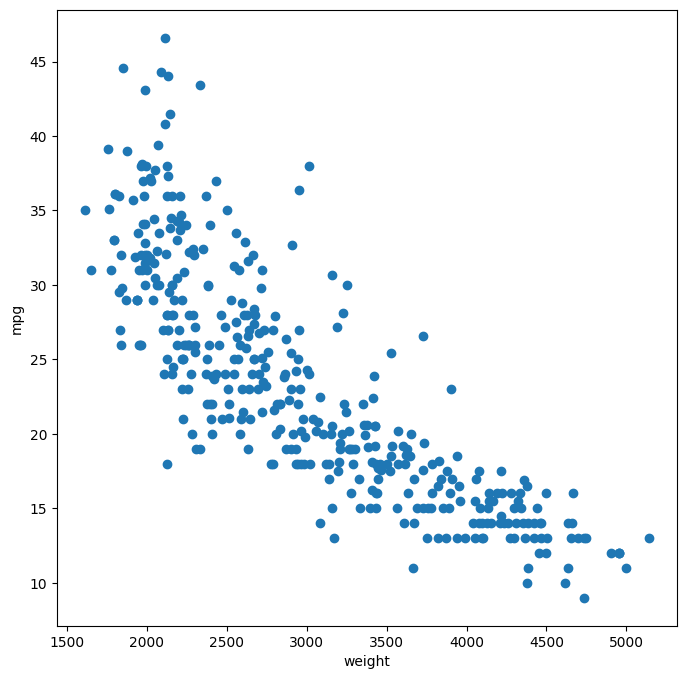

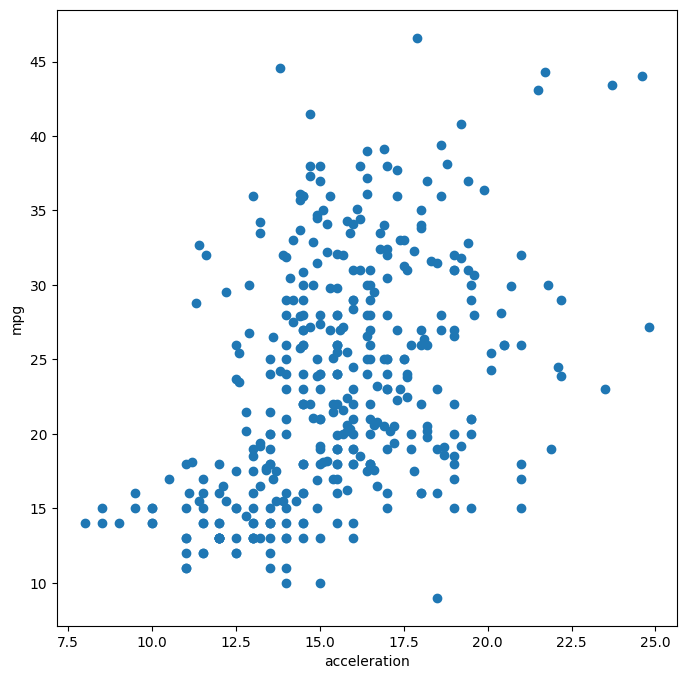

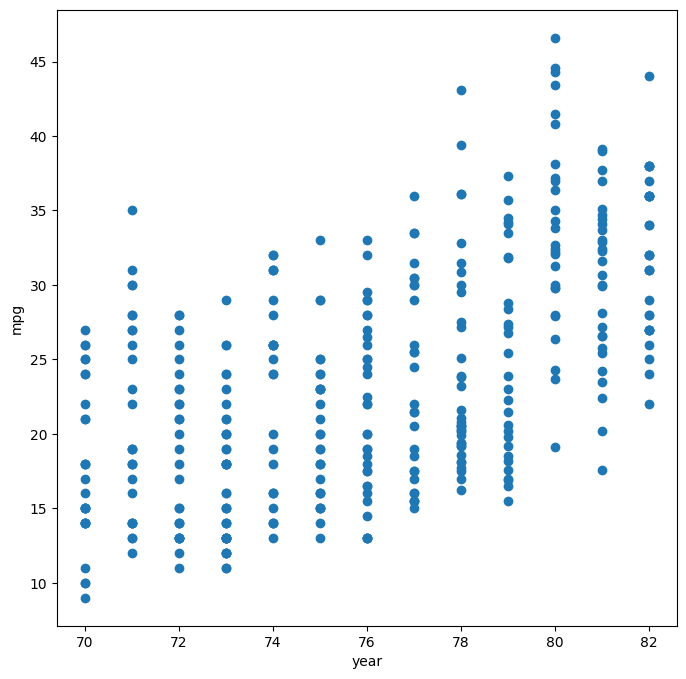

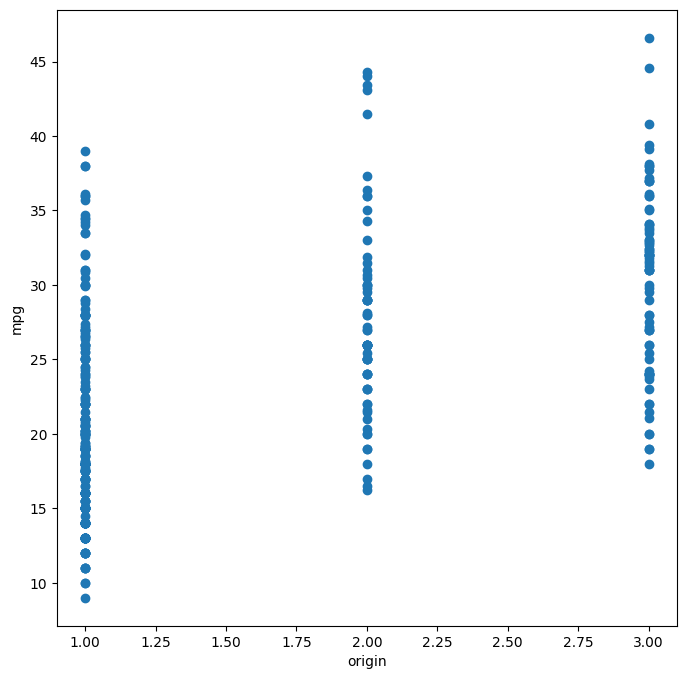

In [359]:
for c in auto.columns:
    if (c != 'mpg'):
        fig, ax = subplots(figsize=(8,8))
        ax.scatter(auto[c],auto['mpg'])
        ax.set_xlabel(c)
        ax.set_ylabel('mpg')


In [402]:
d = {'displacement': 'displacement', 
    'weight': 'weight',
    'acceleration': 'acceleration',
    'horsepower': 'horsepower'}

In [403]:
def polyCV(X,y,poly_param,data):
    score_p = []
    for i in poly_param:
        linreg = LinearRegression()
        design = MS([poly(X.columns[0],i)]).fit(auto)
        X_trans = design.transform(auto)
        score_p.append(-np.mean(cross_val_score(linreg,X_trans,y,scoring='neg_mean_squared_error',cv=5)))
    return score_p

In [404]:
X.columns[0]

'origin'

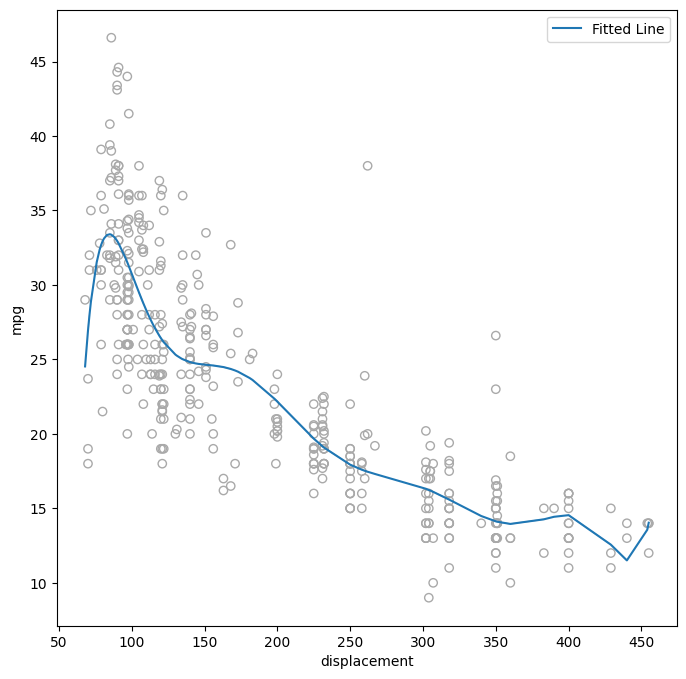

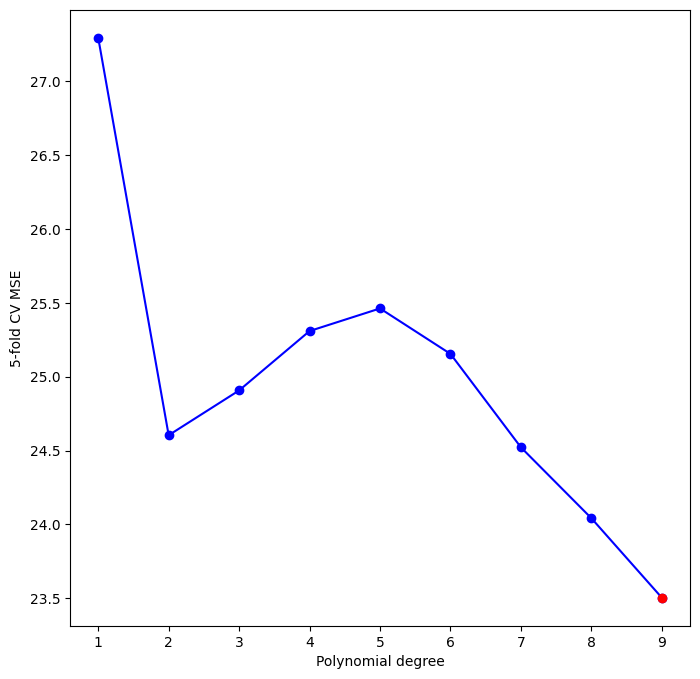

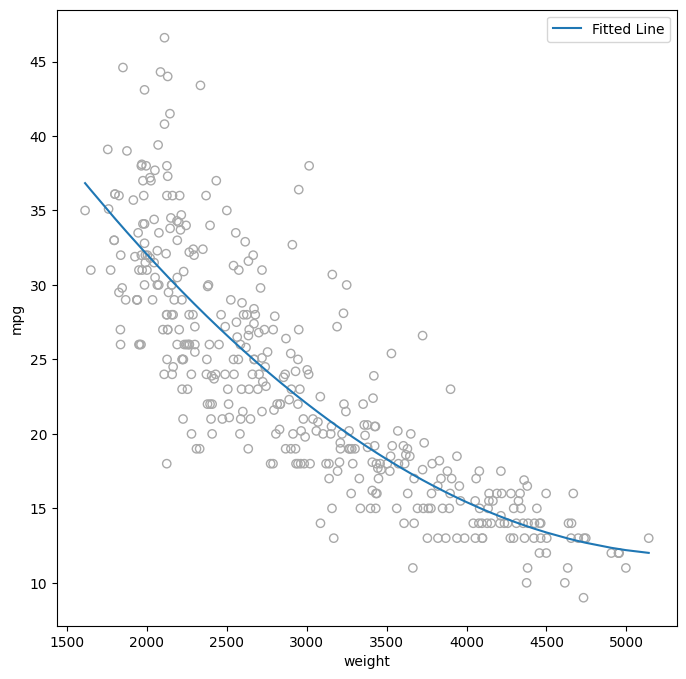

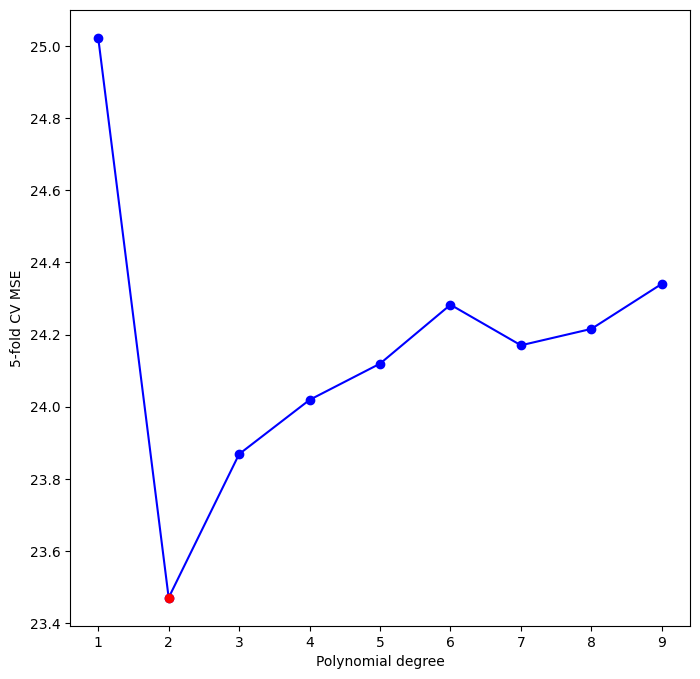

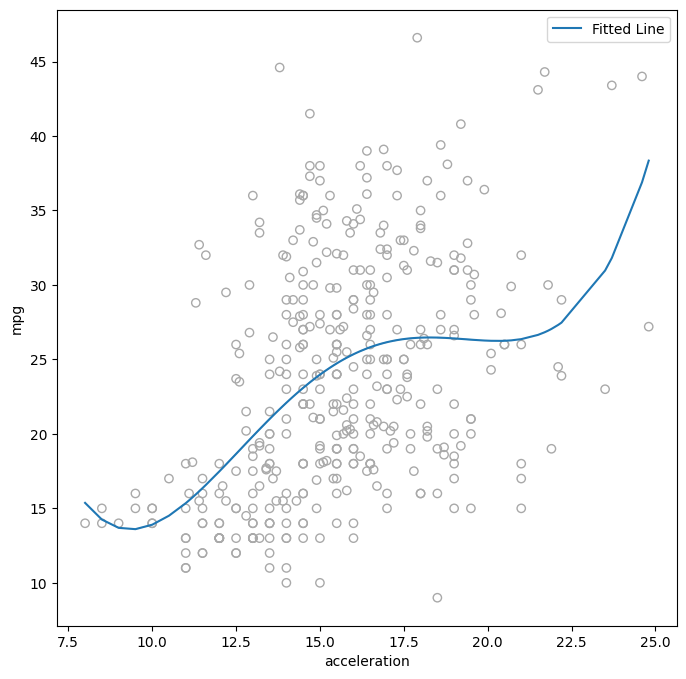

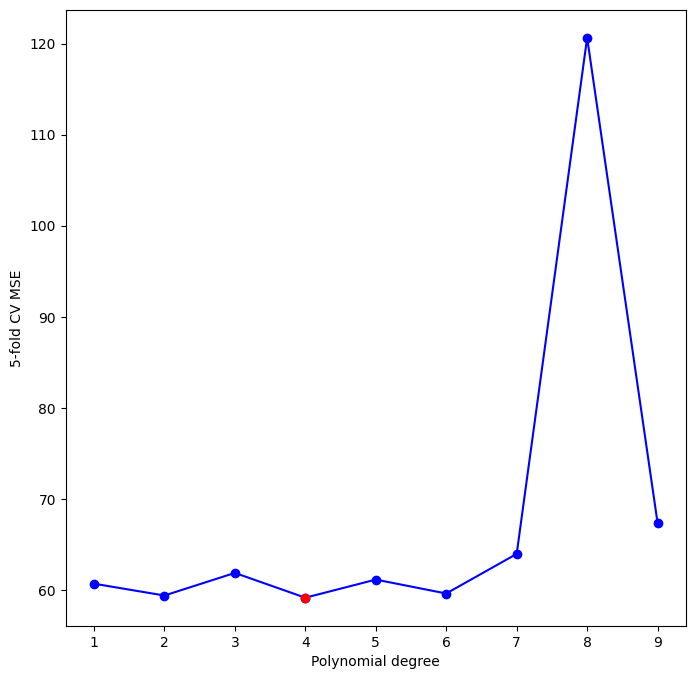

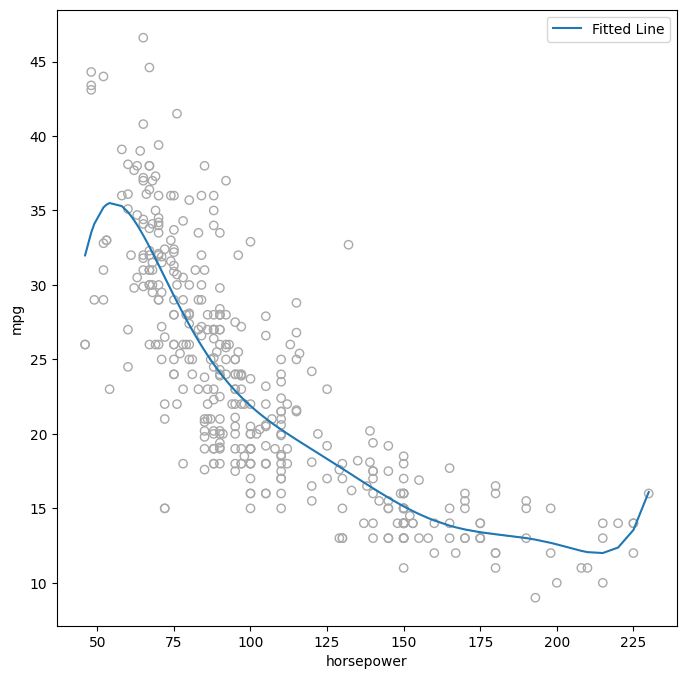

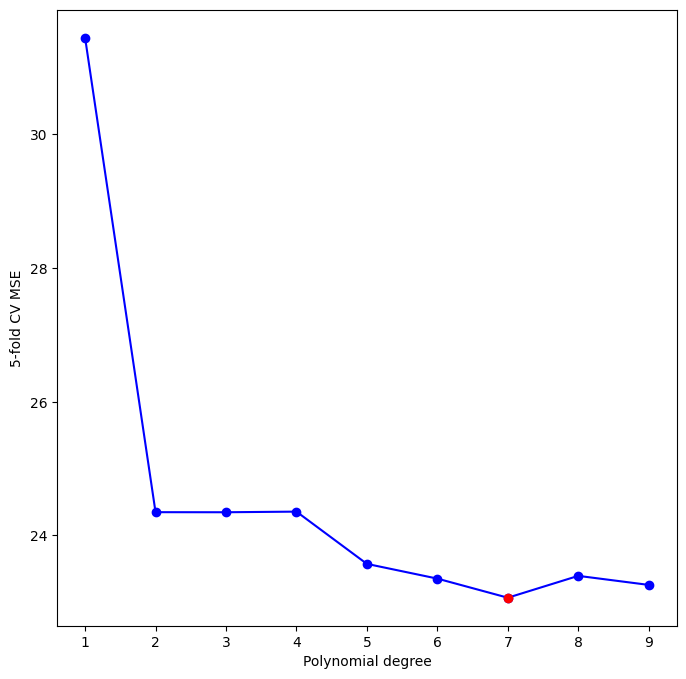

In [412]:
param = range(1,10)
for i in d:
    #design = MS([poly(d[i],4)]).fit(auto)
    y = auto['mpg']
    X = auto[d[i]].to_frame()
    res = polyCV(X,y,param,auto)
    
    # Create a fitted model with the optimal degree for Polynomial Regression
    design = MS([poly(d[i],np.argmin(res)+1)]).fit(auto)
    X_trans = design.transform(auto)
    model = LinearRegression().fit(X_trans,y)
    pred = model.predict(X_trans)
    
    # Plot the fitted model
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(auto[d[i]],auto['mpg'], facecolors='none',edgecolors='darkgrey')
    sns.lineplot(x=auto[d[i]],y=pred,label='Fitted Line')
    ax.set_xlabel(d[i])
    ax.set_ylabel('mpg')
    
    # Plot the CV MSE labeling the lowest degree 
    fig, ax = subplots(figsize=(8,8))
    ax.plot(param,res,marker='o',color='b')
    ax.plot(np.argmin(res)+1,np.min(res),marker='o',color='r')
    ax.set_xlabel('Polynomial degree')
    ax.set_ylabel('5-fold CV MSE')


We can see that acceleration and weight may be fitted with a polynomial although for displacement and horsepower the Polynomial regression exhibits the tail behaviour that is discussed in the chapter and may not necessarily give the best prediction given a test set to work with. And the complexity of the model for horsepower and displacement gives a very high polynomial degree, which may even indicate for overfitting.

7.9

This question uses the variables dis (the weighted mean of distances to five Boston employment centers) and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat dis as the predictor and nox as the response.

In [446]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import statsmodels.api as sm
from ISLP import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler,
                                   PolynomialFeatures)
from ISLP.models import (summarize, 
                        poly,
                        ModelSpec as MS)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings; warnings.simplefilter('ignore')

In [463]:
boston = load_data('Boston')
boston.head()
y = boston['nox']
X = boston['dis']

boston_train, boston_test = train_test_split(boston, test_size=0.33,random_state=0)

X_test.shape

(102, 4)

(a)

Use the poly() function from the ISLP.models module to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.

In [464]:
design = MS([poly(X.name,3)]).fit(boston_train)
X_des = design.transform(boston_train)
y_train = boston_train['nox']

# Apply Polynomial Regression
model = sm.OLS(y_train,X_des).fit()
summarize(model)

coef  std err        t  P>|t|
intercept               0.5577    0.003  163.242    0.0
poly(dis, degree=3)[0] -1.6314    0.063  -25.936    0.0
poly(dis, degree=3)[1]  0.7207    0.063   11.457    0.0
poly(dis, degree=3)[2] -0.2610    0.063   -4.149    0.0

<bound method Axes.legend of <Axes: title={'center': 'Test Data'}, xlabel='dis', ylabel='nox'>>

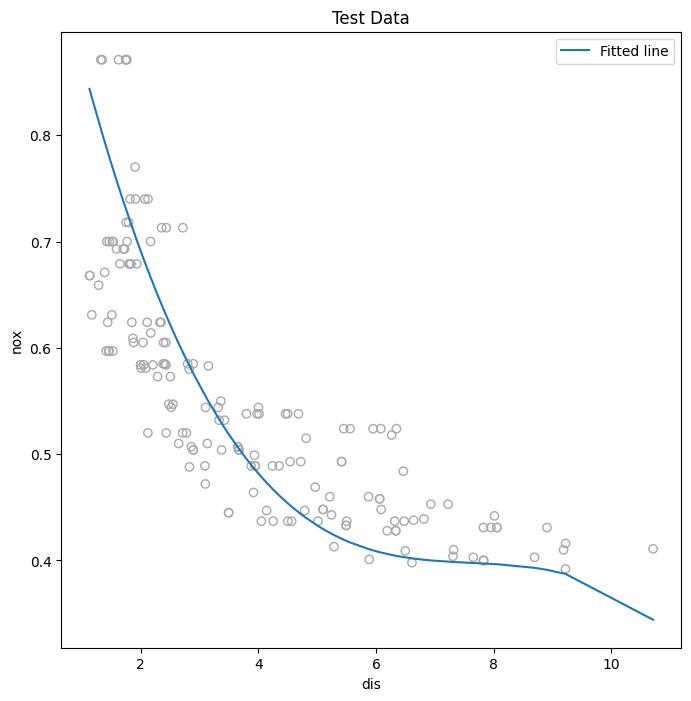

In [469]:
test_de = MS([poly(X.name,3)]).fit(boston_test)
X_test = test_de.transform(boston_test)
y_test = boston_test['nox']

y_pred = model.predict(X_test)

fig, ax = subplots(figsize=(8,8))
ax.scatter(boston_test['dis'],y_test,facecolor='none',edgecolor='darkgrey')
sns.lineplot(x=boston_test['dis'],y=y_pred,label='Fitted line')
ax.set_xlabel('dis')
ax.set_ylabel('nox')
ax.set_title('Test Data')
ax.legend

<bound method Axes.legend of <Axes: title={'center': 'Training Data'}, xlabel='dis', ylabel='nox'>>

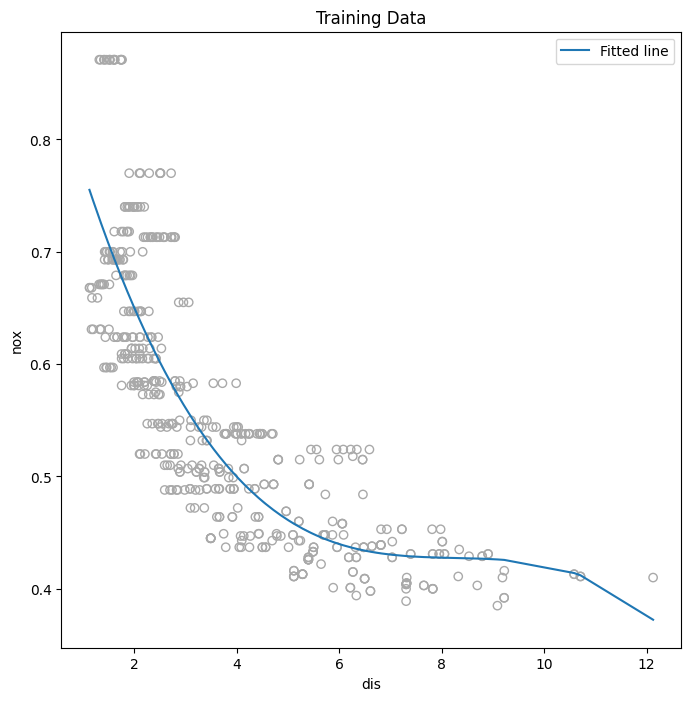

In [470]:
design = MS([poly(X.name,3)]).fit(boston)
X_trans = test_de.transform(boston)

model1 = sm.OLS(y,X_trans).fit()
y_pred = model1.predict(X_trans)

fig, ax = subplots(figsize=(8,8))
ax.scatter(boston['dis'],y,facecolor='none',edgecolor='darkgrey')
sns.lineplot(x=boston['dis'],y=y_pred,label='Fitted line')
ax.set_xlabel('dis')
ax.set_ylabel('nox')
ax.set_title('Training Data')
ax.legend

(b)

Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

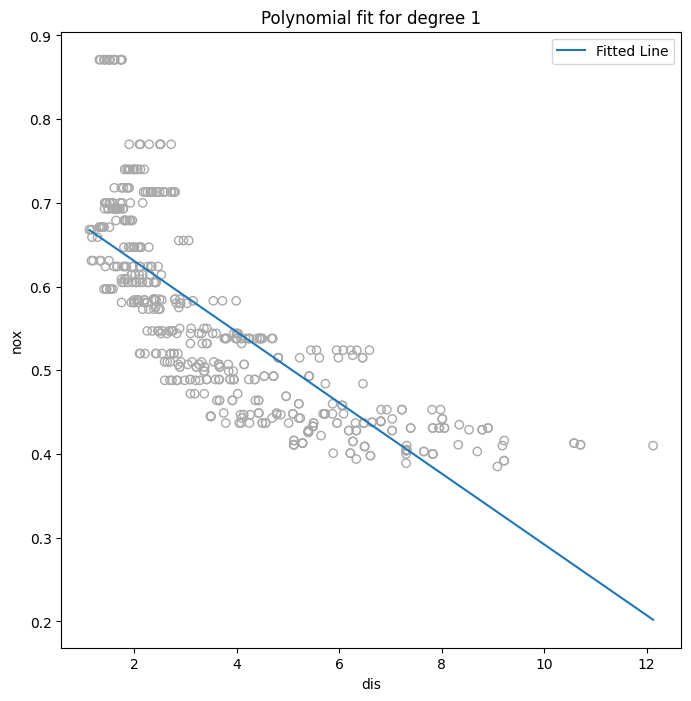

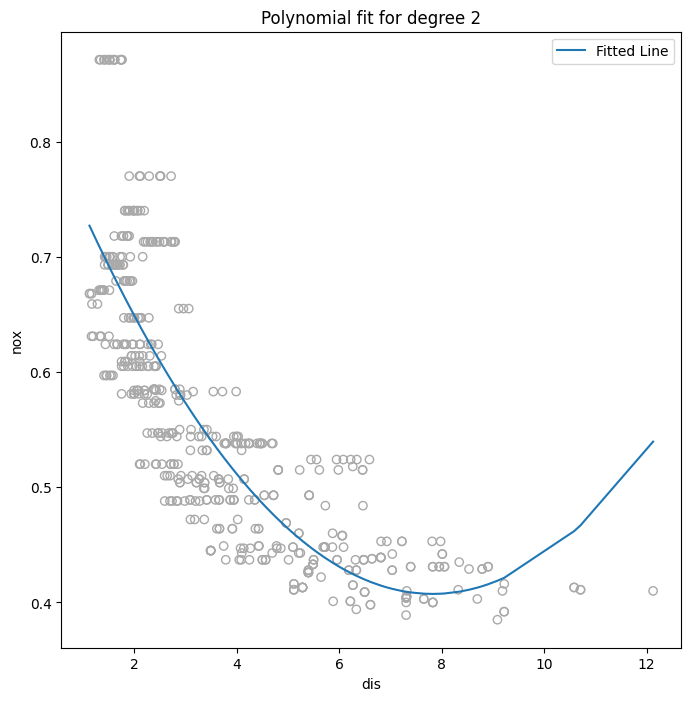

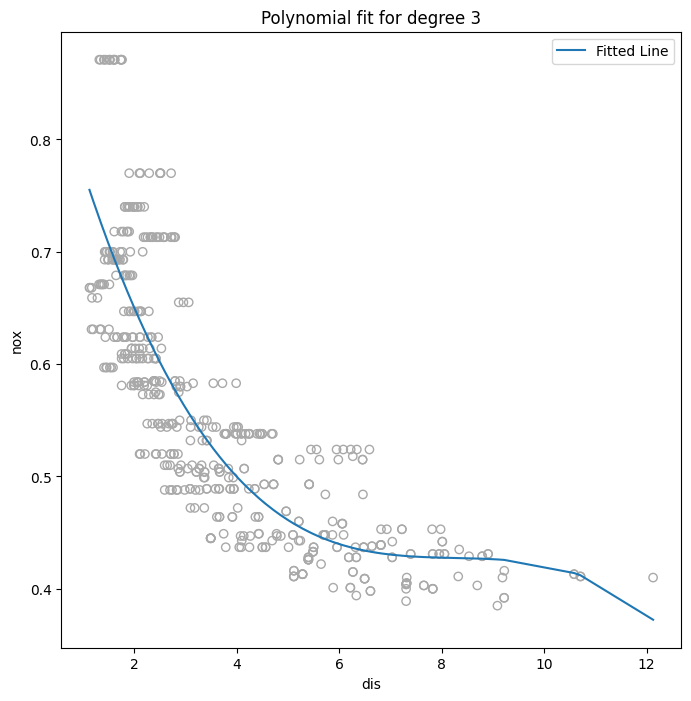

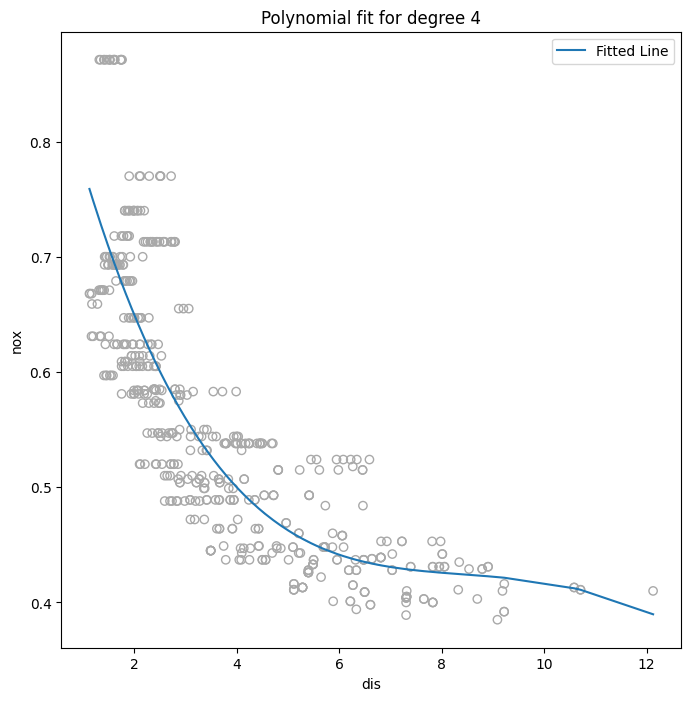

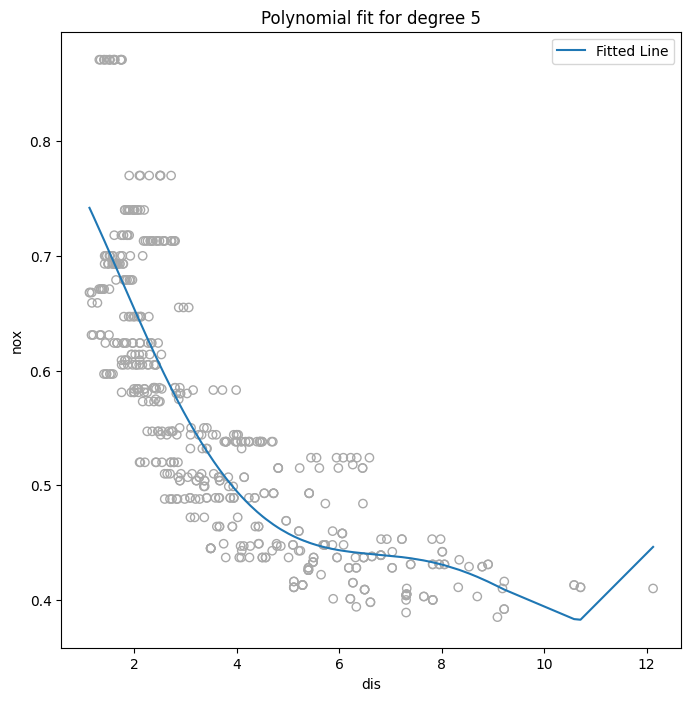

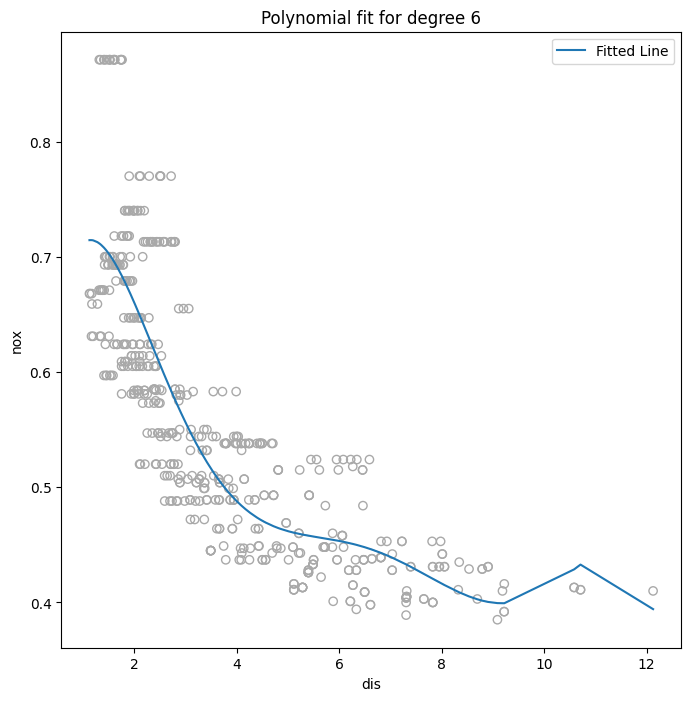

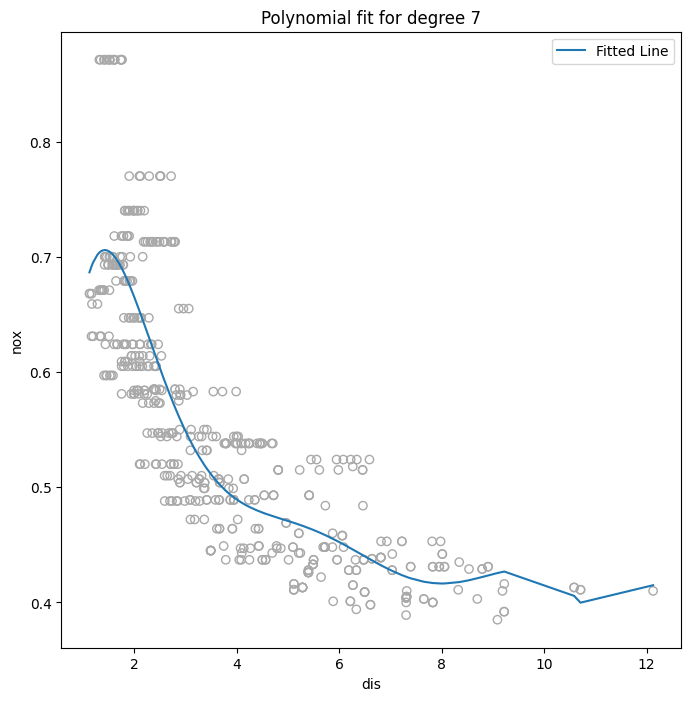

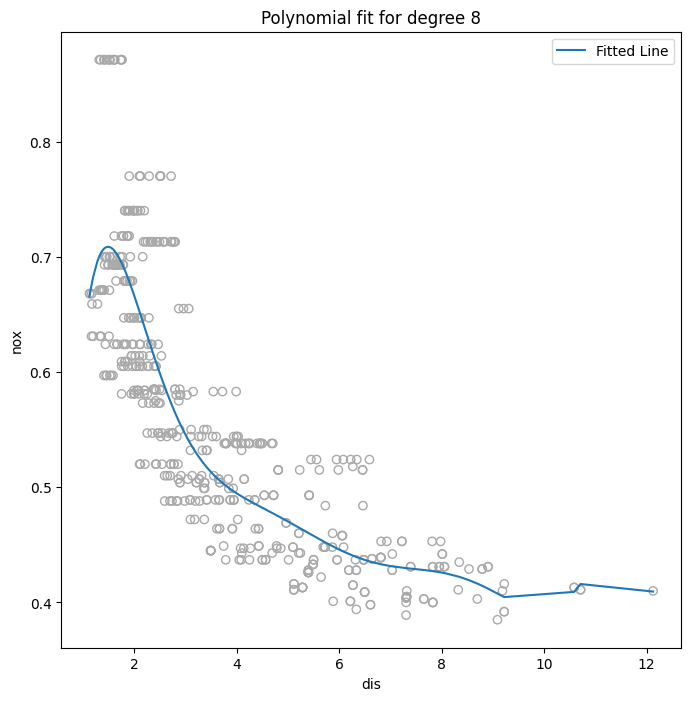

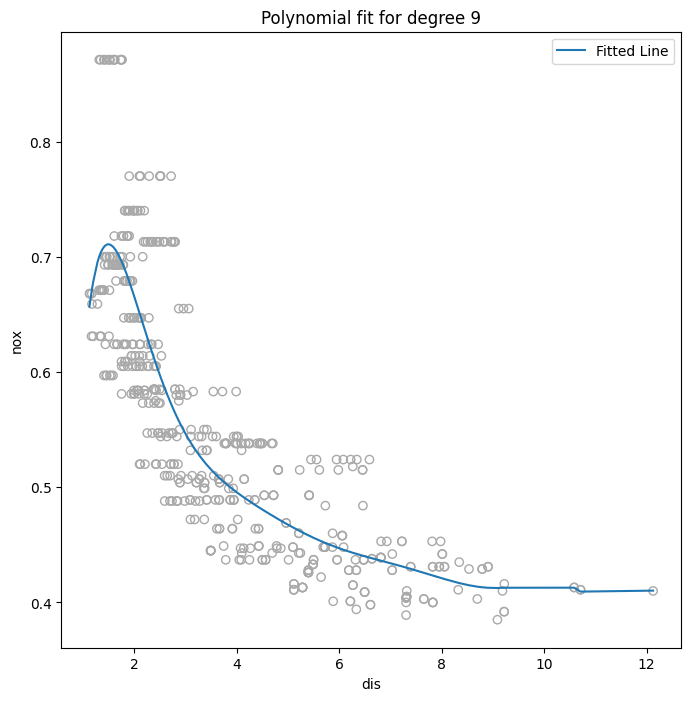

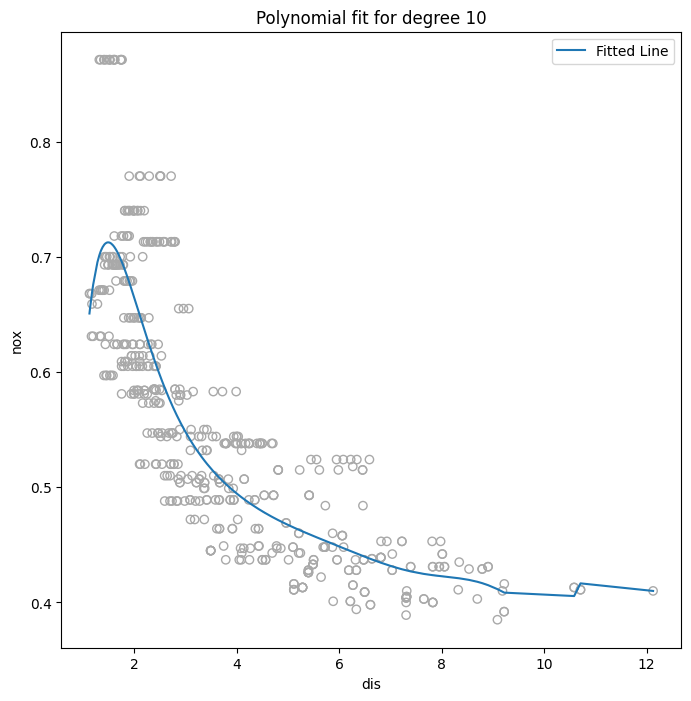

In [477]:
RSS = []
for deg in range(1,11):
    design = MS([poly('dis',deg)]).fit(boston)
    X_trans = design.transform(boston)

    # Use Linear Regression to fit the polynomial model
    model = sm.OLS(y,X_trans).fit()
    y_pred = model.predict(X_trans)

    RSS.append(np.sum((y-y_pred)**2))
    # plot the data points and the fitted model
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(X,y,facecolor='none',edgecolor='darkgrey')
    sns.lineplot(x=X,y=y_pred,label='Fitted Line')
    ax.set_xlabel('dis')
    ax.set_ylabel('nox')
    ax.set_title('Polynomial fit for degree {0}'.format(deg))

Text(0, 0.5, 'RSS')

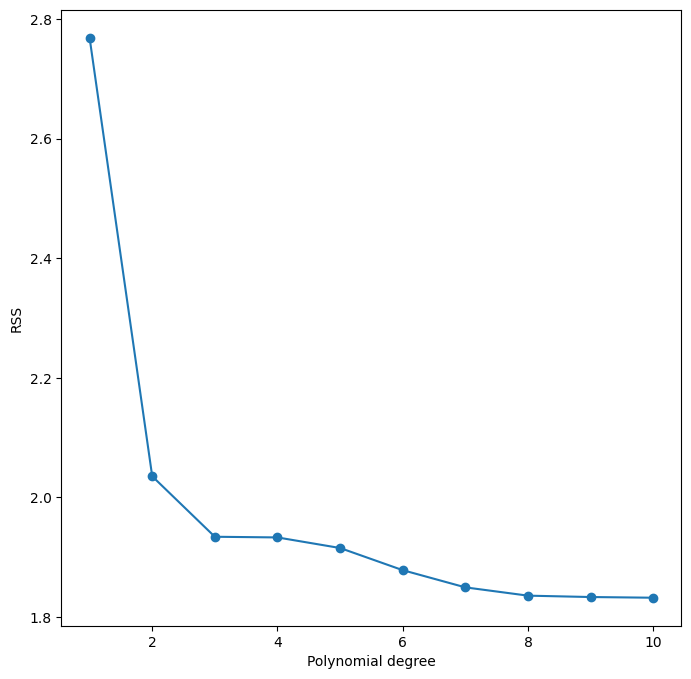

In [479]:
fig, ax = subplots(figsize=(8,8))
ax.plot(range(1,len(RSS)+1),RSS,marker='o')
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('RSS')

(c)

Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

In [516]:
degree = range(0,11)
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('estimator', LinearRegression())])
pipe.fit(X,y)

param_grid = {'poly__degree': degree}
K = 5
kfold = skm.KFold(K,
                 random_state=0,
                 shuffle=True)
grid = skm.GridSearchCV(pipe,
                       param_grid,
                       cv=5,
                       scoring='neg_mean_squared_error')
grid.fit(X,y)

res = -grid.cv_results_['mean_test_score']

array([           nan, 6.03210922e-03, 4.57038488e-03, 4.64736746e-03,
       4.75611848e-03, 4.96965026e-03, 2.20833239e-02, 8.60110445e-02,
       2.41799439e+00, 1.30950088e-01, 8.46494480e+01])

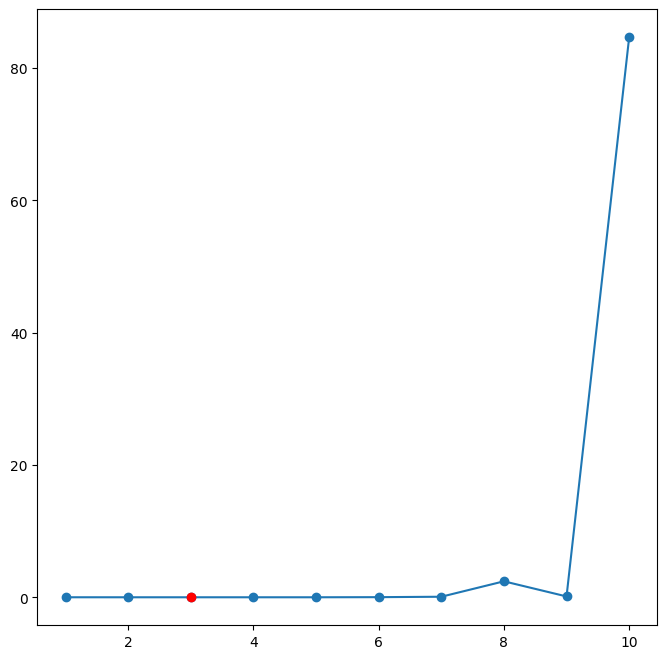

In [517]:
fig, ax = subplots(figsize=(8,8))
ax.plot(degree,list(res),marker='o')
ax.plot(np.nanargmin(res)+1,np.nanmin(res),marker='o',color='r')

We see that a polynomial of degree 3 gives us the best resulting polynomial fit
__________________________________________________________________________________________________

(d)

Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

{'whiskers': [<matplotlib.lines.Line2D at 0x225458fc250>,
 'caps': [<matplotlib.lines.Line2D at 0x225458fe8c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x225458ffee0>],
 'medians': [<matplotlib.lines.Line2D at 0x225458fd7e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x225458fd690>],
 'means': []}

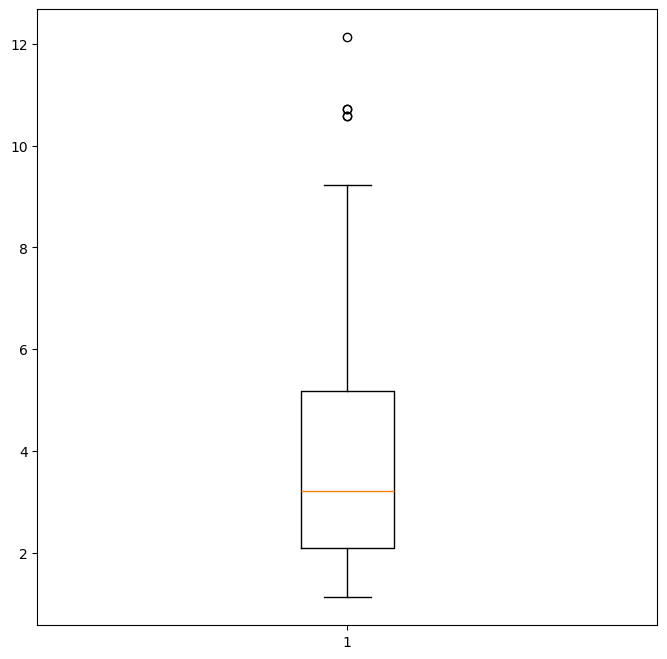

In [524]:
fig, ax = subplots(figsize=(8,8))
ax.boxplot(X)


Text(0.5, 1.0, 'B-spline fit')

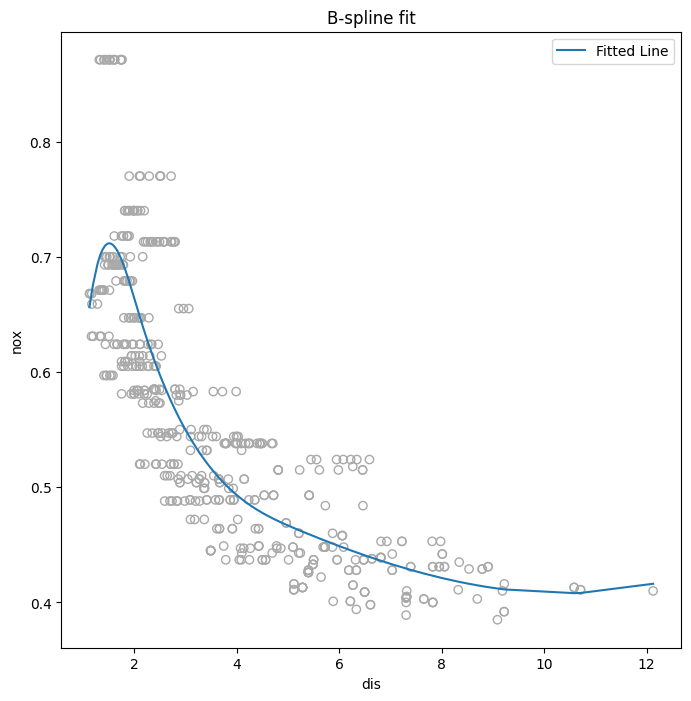

In [557]:
bs_dis = MS([bs('dis',internal_knots=[np.percentile(X, 25),np.percentile(X, 50),np.percentile(X,75)])])
Xbs = bs_dis.fit_transform(boston)
model = sm.OLS(y,Xbs).fit()
X = boston['dis']
y_pred = model.predict(Xbs)
fig, ax = subplots(figsize=(8,8))
ax.scatter(X,y,facecolor='none',edgecolor='darkgrey')
sns.lineplot(x=X,y=y_pred,label='Fitted Line')
ax.set_xlabel('dis')
ax.set_ylabel('nox')
ax.set_title('B-spline fit')

In [549]:
BSpline(df=8).fit(X).internal_knots_

array([1.85131667, 2.38403333, 3.20745   , 4.3257    , 6.0622    ])

(e)

Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

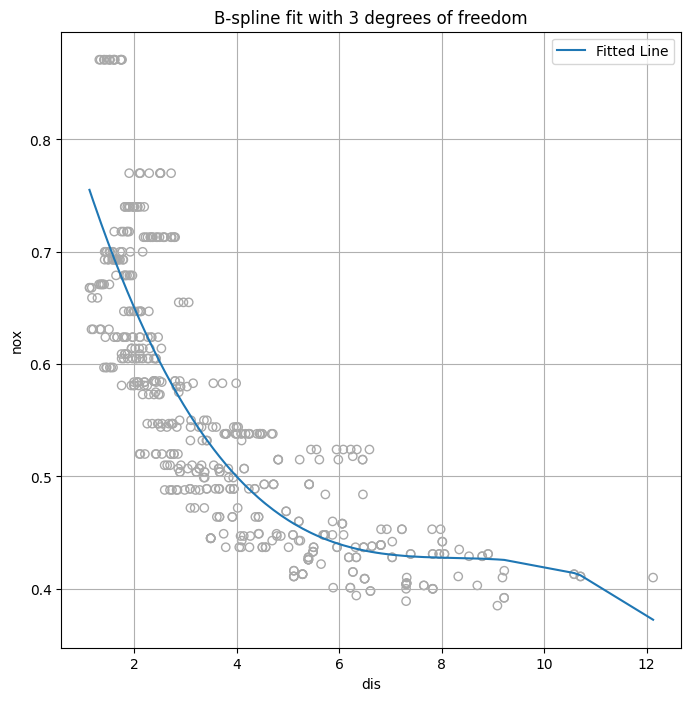

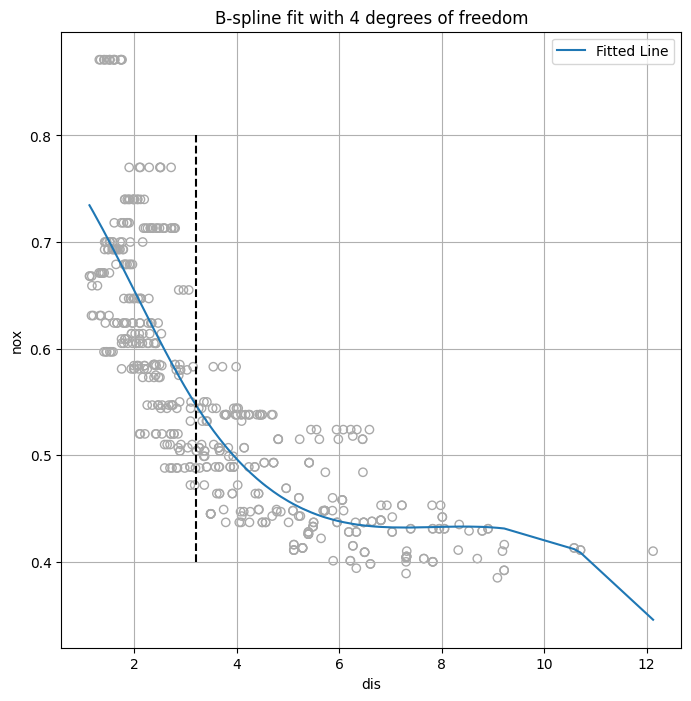

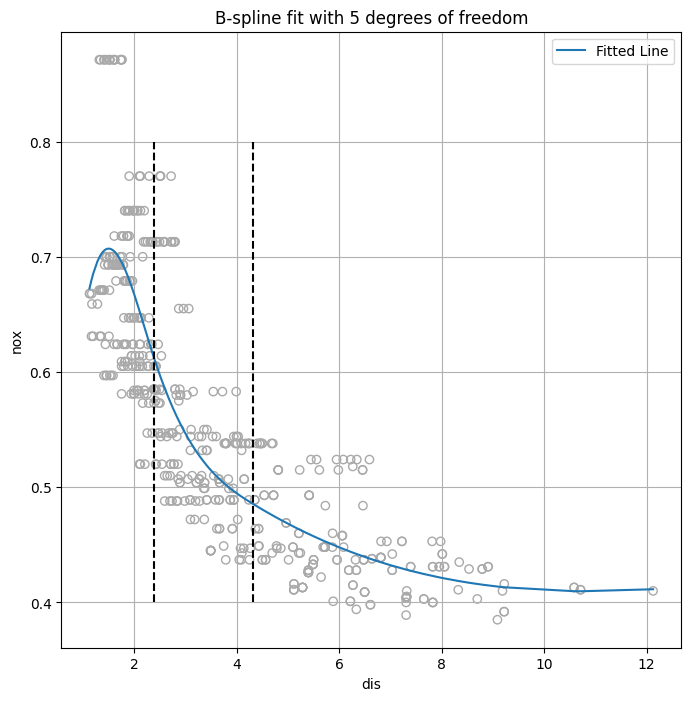

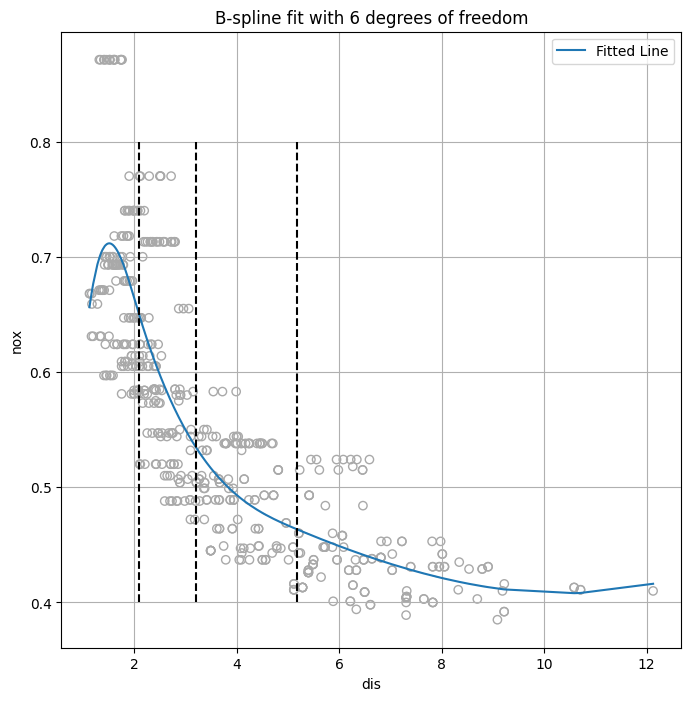

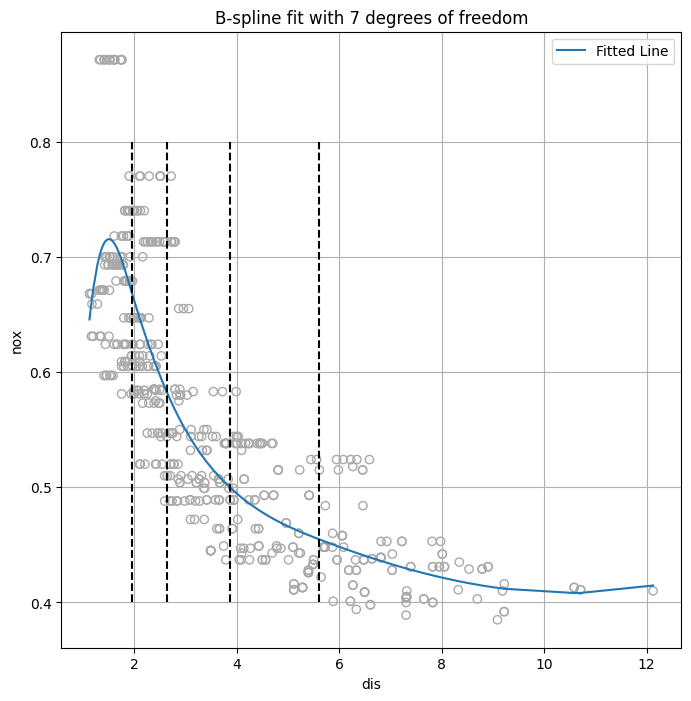

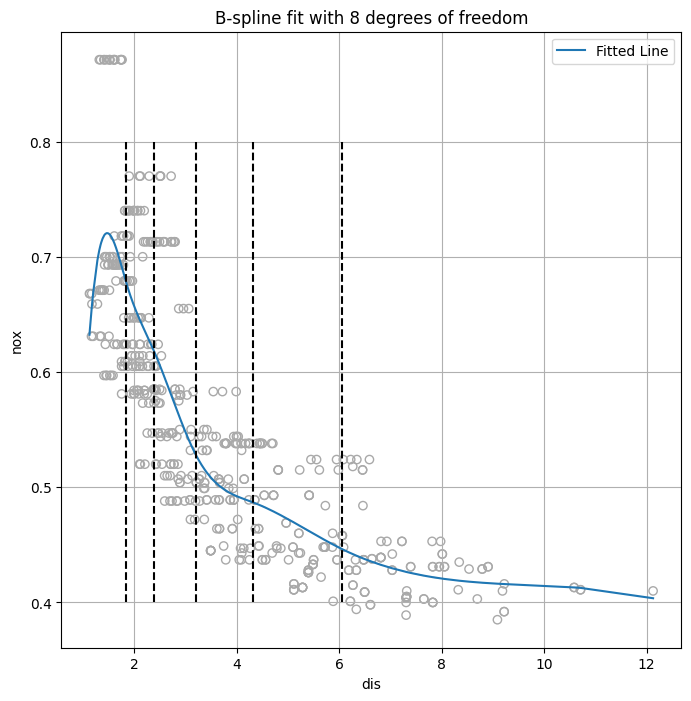

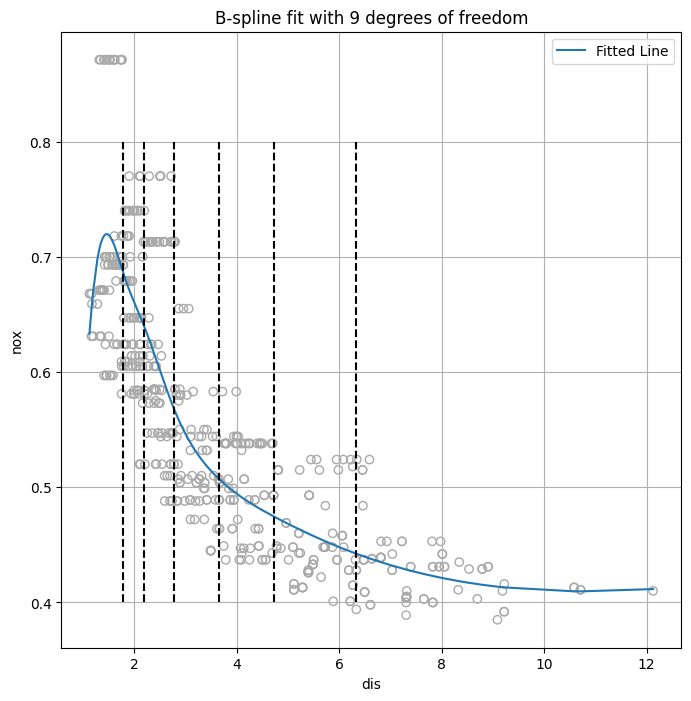

In [570]:
X = boston['dis']
for fr in range(3,10):
    bs_dis = MS([bs('dis', internal_knots=BSpline(df=fr).fit(X).internal_knots_)])
    Xbs = bs_dis.fit_transform(boston)
    model = sm.OLS(y, Xbs).fit()
    y_pred = model.predict(Xbs)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(X, y, facecolor='none', edgecolor='darkgrey')
    sns.lineplot(x=X, y=y_pred, label='Fitted Line')
    ax.vlines(x=BSpline(df=fr).fit(X).internal_knots_, ymin=0.4, ymax=0.8, colors='k', linestyles='--')
    ax.grid()
    ax.set_xlabel('dis')
    ax.set_ylabel('nox')
    ax.set_title('B-spline fit with {0}'.format(fr) + ' degrees of freedom')

(f)

Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

In [589]:
def bsCV(X,y,param):
    score = []
    kfold = skm.KFold(10,
                      random_state=0,
                      shuffle=True)
    for fr in param:
        bs_dis = MS([bs('dis', internal_knots=BSpline(df=fr).fit(X).internal_knots_)])
        Xbs = bs_dis.fit_transform(boston)
        linreg = LinearRegression()
        score.append(-np.mean(cross_val_score(linreg,Xbs,y,cv=kfold,scoring='neg_mean_squared_error')))
    return score

In [590]:
param = range(3,10)

res = bsCV(X,y,param)
res

[0.0038537042517257903,
 0.003866096686992191,
 0.003699350811317302,
 0.0036967349417863504,
 0.003693532519505114,
 0.0036848471896700533,
 0.0037191648928449747]

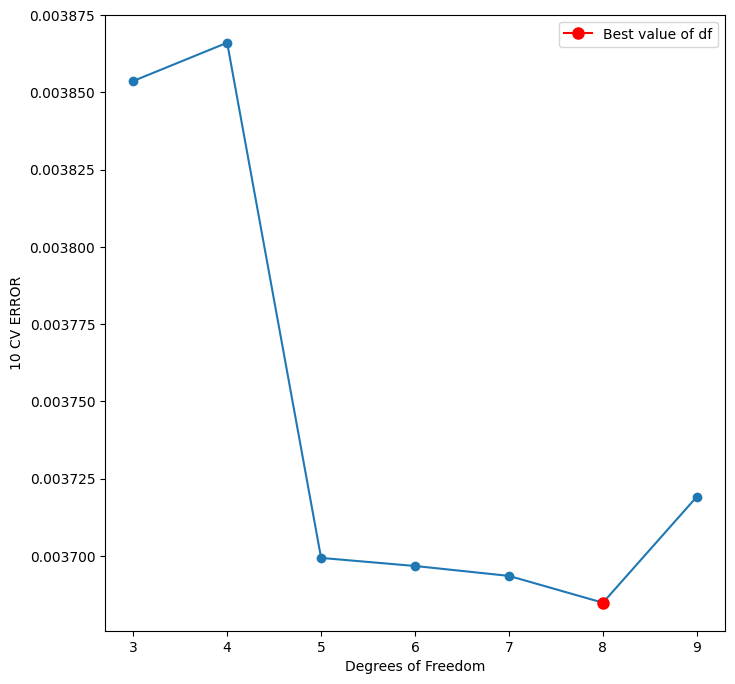

In [591]:
fig, ax = subplots(figsize=(8,8))
ax.plot(np.arange(3,10),list(res),marker = 'o')
ax.plot(np.argmin(res)+3,np.min(list(res)),marker = 'o',markersize = 8,color = 'r',label = 'Best value of df')
ax.set_xlabel('Degrees of Freedom')
ax.set_ylabel('10 CV ERROR')
ax.legend()

7.10

This question relates to the College data set.

In [110]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ISLP import load_data
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler,
                                   PolynomialFeatures)
from ISLP.models import (summarize, 
                        poly,
                        Stepwise,
                        sklearn_selected,
                        ModelSpec as MS)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings; warnings.simplefilter('ignore')

college = load_data('College')
college.head()

Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0     Yes  1660    1232     721         23         52         2885   
1     Yes  2186    1924     512         16         29         2683   
2     Yes  1428    1097     336         22         50         1036   
3     Yes   417     349     137         60         89          510   
4     Yes   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2       12.9           30    8735         54  
3        7.7           37   19016         59  
4       11.9            2   10922         15

In [111]:
X = college.drop(['Outstate'],axis=1)
y = college['Outstate']

(a)

 Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=0)

In [113]:
def nCp(sigma2, estimator, X, Y):
    #Negative Cp statistic
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

In [114]:
design = MS(X_train.columns).fit(X_train)
X = design.transform(X_train)
sigma2 = sm.OLS(y_train,X).fit().scale

neg_Cp = partial(nCp,sigma2)

In [115]:
stragety = Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))

data_Cp = sklearn_selected(sm.OLS,stragety,scoring=neg_Cp)
data_Cp.fit(X_train,y_train)
data_Cp.selected_state_

('Accept',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Personal',
 'Private',
 'Room.Board',
 'Terminal',
 'Top10perc',
 'perc.alumni')

(b)

Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In [109]:
# Create a feature grid containing all features that we got in forward stepwise selection
new_design = MS(data_Cp.selected_state_).fit(X_train)
#X_new = new_design.transform(X_train)
# Drop intercept since LinearGAM provides an intercept
#X_new = X_new.drop('intercept',axis=1)
#X_new
new_design

ModelSpec(terms=('Accept', 'Expend', 'F.Undergrad', 'Grad.Rate', 'Personal',
                 'Private01', 'Room.Board', 'Terminal', 'Top10perc',
                 'perc.alumni'))

In [99]:
gam = LinearGAM(s_gam(0) + s_gam(1) + s_gam(2) + s_gam(3) + 
                s_gam(4) + s_gam(5) + s_gam(6) + s_gam(7) + 
               s_gam(8) + s_gam(9)).fit(X_new, y_train)
gam.summary()
gamGVC = gam.statistics_['GCV']

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     83.1903
Link Function:                     IdentityLink Log Likelihood:                                 -6171.4888
Number of Samples:                          388 AIC:                                            12511.3582
                                                AICc:                                           12558.7292
                                                GCV:                                          5175682.4842
                                                Scale:                                        3226666.7928
                                                Pseudo R-Squared:                                   0.8459
Feature Function                  Lam

In [100]:
lams = np.random.rand(30, 10) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 1e3

gam.gridsearch(X_new, y_train, lam=lams)
gam.summary()
random_gamGCV = gam.statistics_['GCV']

100% (30 of 30) |########################| Elapsed Time: 0:00:07 Time:  0:00:070000


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     55.9936
Link Function:                     IdentityLink Log Likelihood:                                 -6174.5771
Number of Samples:                          388 AIC:                                            12463.1413
                                                AICc:                                           12483.1729
                                                GCV:                                          4370810.7204
                                                Scale:                                        3252451.8045
                                                Pseudo R-Squared:                                   0.8308
Feature Function                  Lam

In [101]:
random_gamGCV<gamGVC

True

In [102]:
# Create a new GAM model based on the lambda we got
gam = LinearGAM(s_gam(0)+ s_gam(1)+s_gam(2)+s_gam(3)+s_gam(4)+ f_gam(5, lam=5) 
                +s_gam(6)+s_gam(7)+s_gam(8)+s_gam(9))
gam = gam.fit(X_new, y_train)

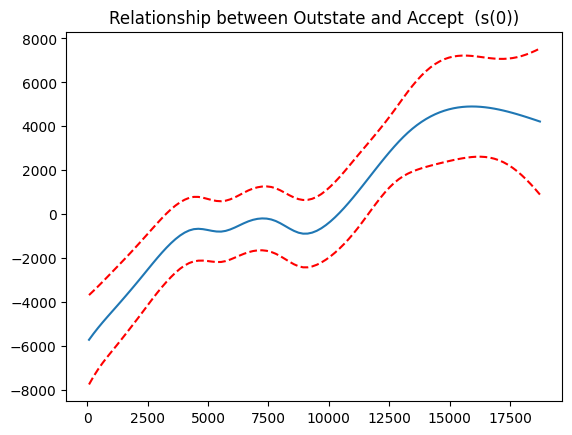

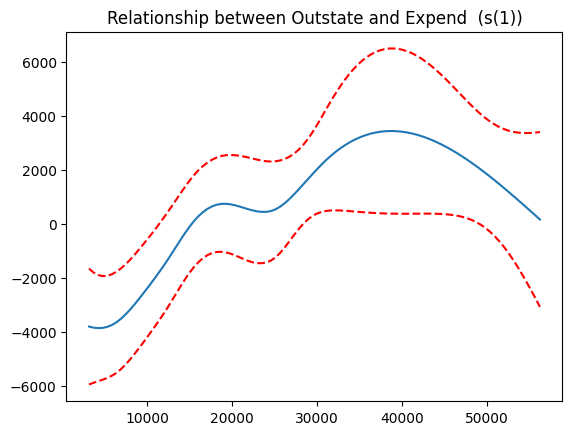

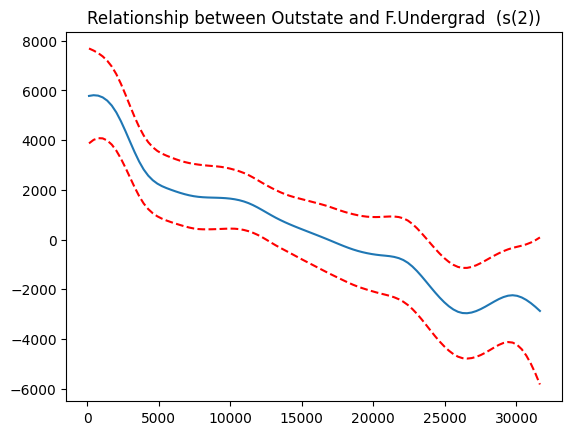

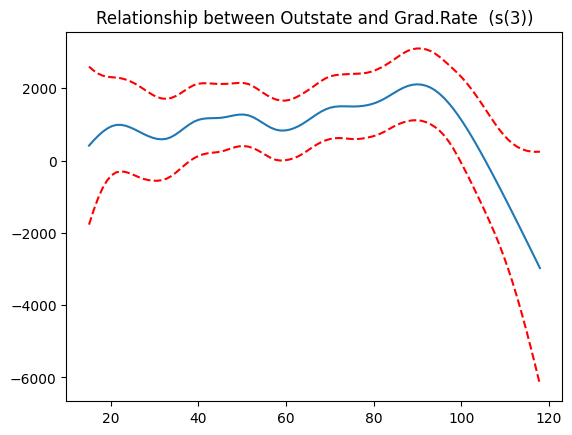

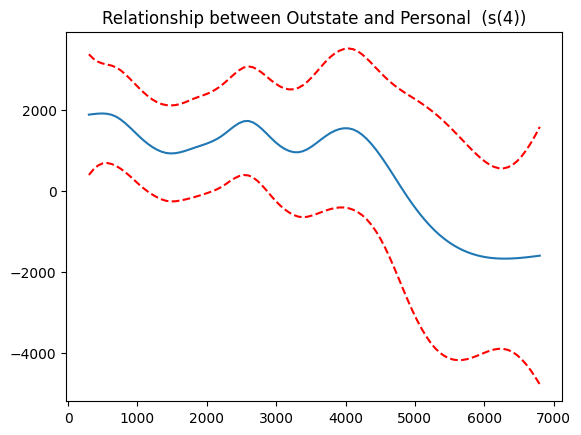

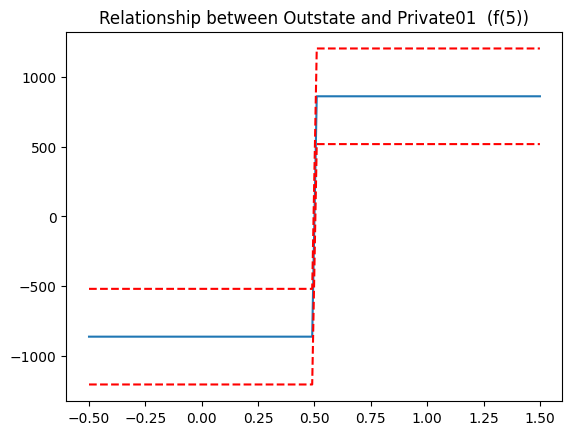

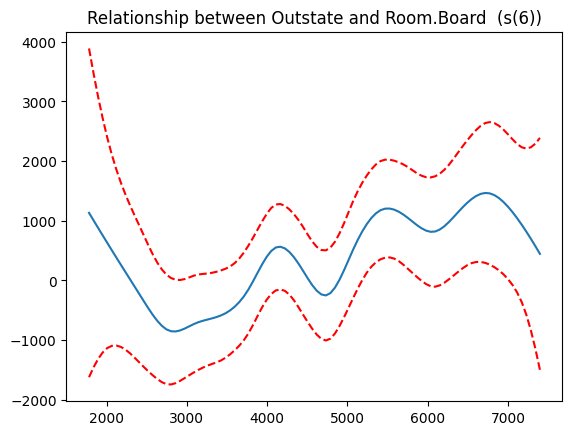

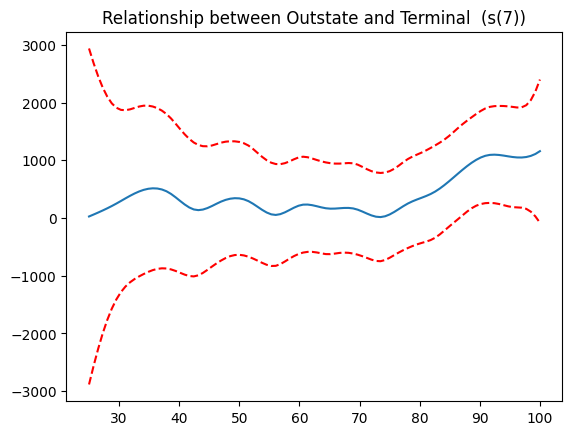

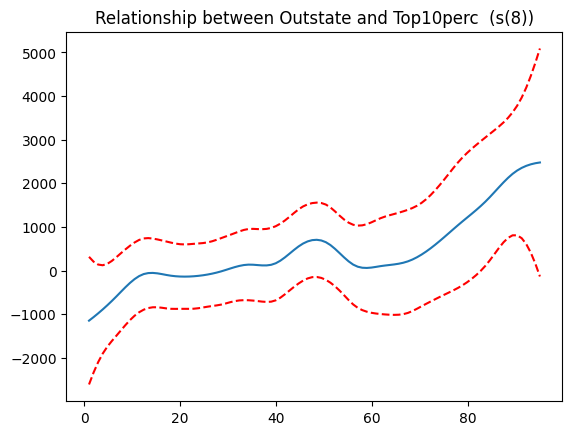

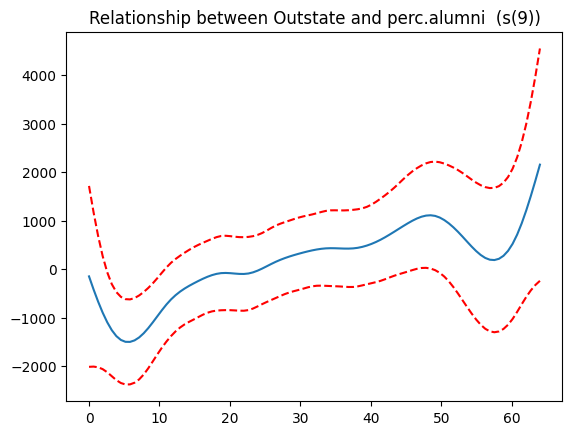

In [103]:
k = 0
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title("Relationship between Outstate and {0} ".format(X_new.columns[k]) + " ({0})".format(repr(term)))
    plt.show()
    k += 1

From the partial dependence we can see for the first relationship between Out-of-state tuition

(c)

Evaluate the model obtained on the test set, and explain the results obtained.

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
new_design = MS(data_Cp.selected_state_).fit(X_test)
X_new_test = new_design.transform(X_test)
X_new_test = X_new_test.drop('intercept',axis=1)
test_preds=gam.predict(X_new_test)
r2_score(y_test,test_preds)

hello World 


(d)

For which variables, if any, is there evidence of a non-linear relationship with the response?

array([[<Axes: xlabel='Apps', ylabel='Apps'>,
        <Axes: xlabel='Accept', ylabel='Apps'>,
        <Axes: xlabel='Enroll', ylabel='Apps'>,
        <Axes: xlabel='Top10perc', ylabel='Apps'>,
        <Axes: xlabel='Top25perc', ylabel='Apps'>,
        <Axes: xlabel='F.Undergrad', ylabel='Apps'>,
        <Axes: xlabel='P.Undergrad', ylabel='Apps'>,
        <Axes: xlabel='Outstate', ylabel='Apps'>,
        <Axes: xlabel='Room.Board', ylabel='Apps'>,
        <Axes: xlabel='Books', ylabel='Apps'>,
        <Axes: xlabel='Personal', ylabel='Apps'>,
        <Axes: xlabel='PhD', ylabel='Apps'>,
        <Axes: xlabel='Terminal', ylabel='Apps'>,
        <Axes: xlabel='S.F.Ratio', ylabel='Apps'>,
        <Axes: xlabel='perc.alumni', ylabel='Apps'>,
        <Axes: xlabel='Expend', ylabel='Apps'>,
        <Axes: xlabel='Grad.Rate', ylabel='Apps'>],
       [<Axes: xlabel='Apps', ylabel='Accept'>,
        <Axes: xlabel='Accept', ylabel='Accept'>,
        <Axes: xlabel='Enroll', ylabel='Accept'>,
    

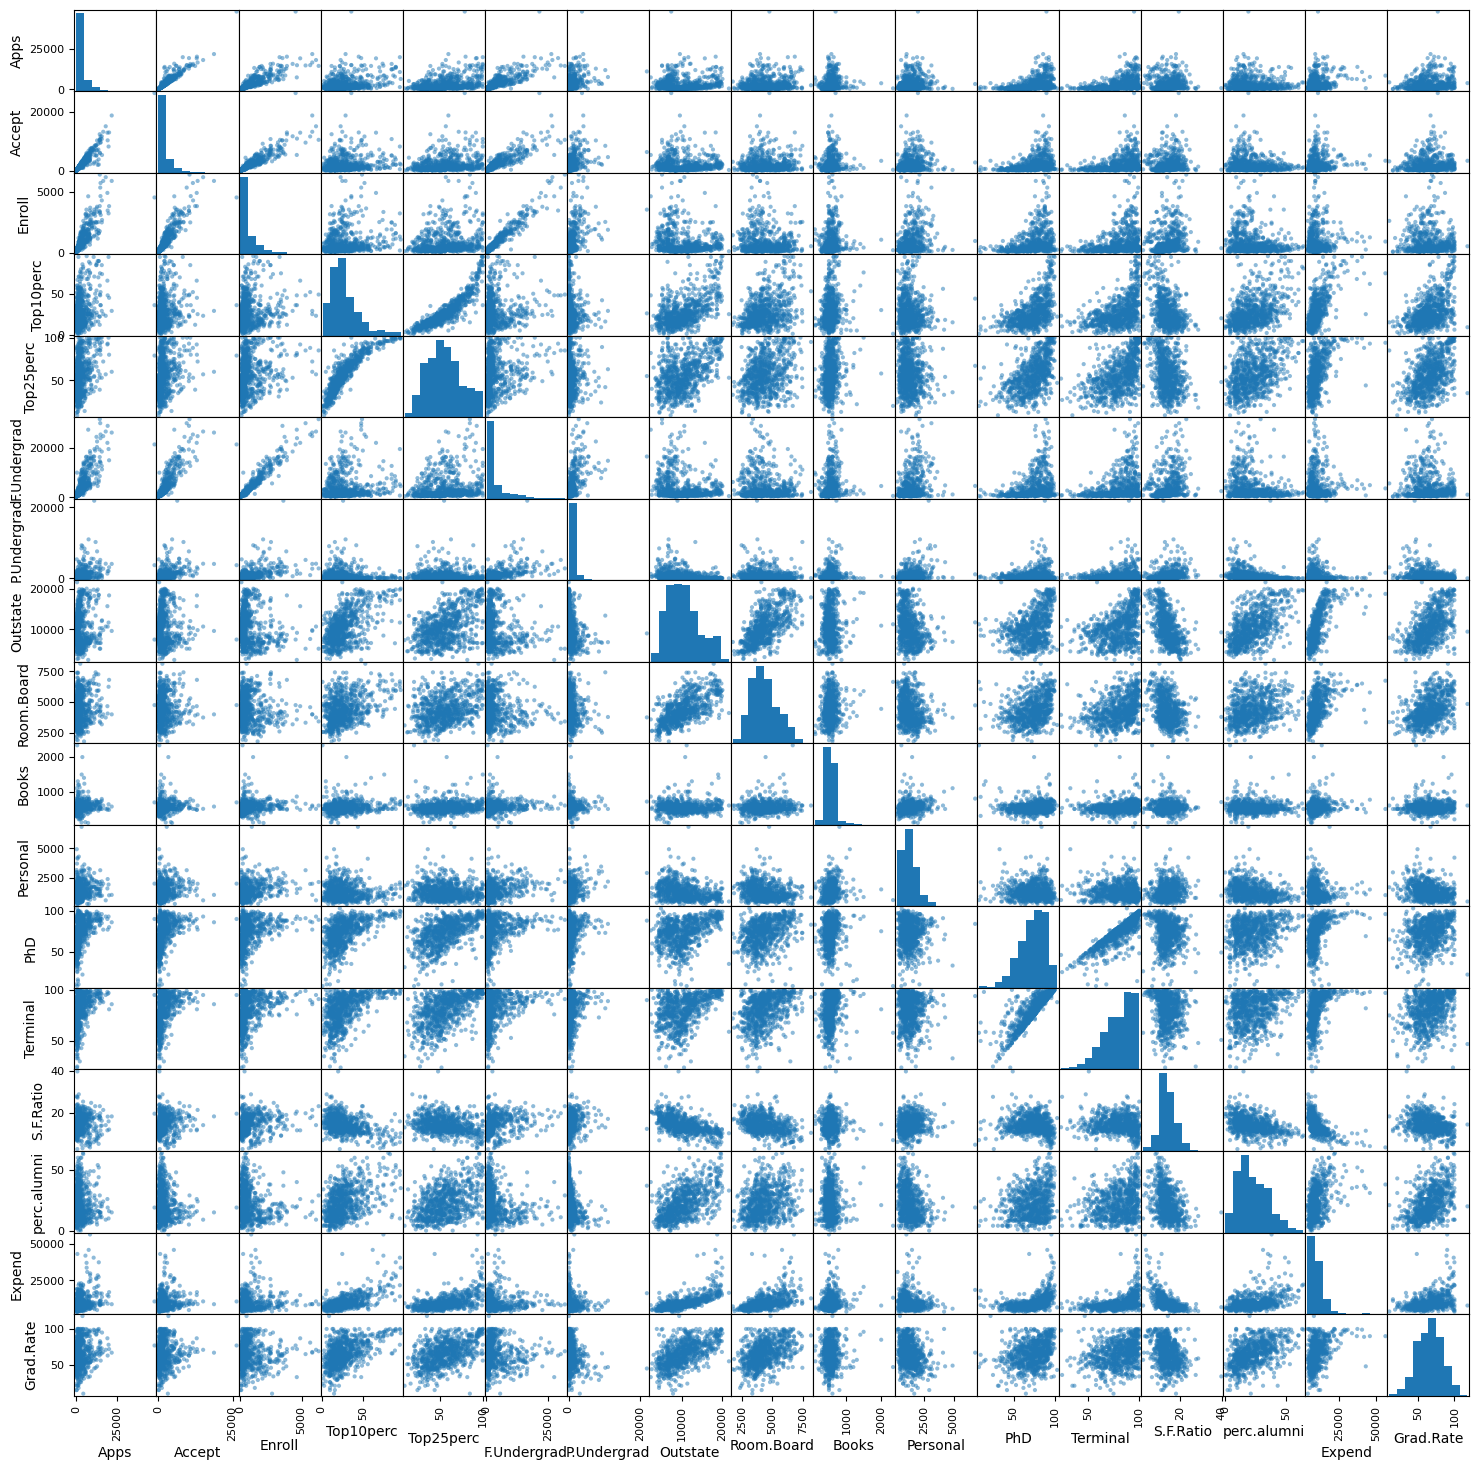

In [780]:
pd.plotting.scatter_matrix(college, alpha=0.5, figsize=(18,18))